**Step 1: Import Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


**Step 2: Load CIFAR-10 and CIFAR-100**

In [ ]:
# Load CIFAR-10
(cifar10_train, cifar10_val, cifar10_test), cifar10_meta = tfds.load(
    'cifar10',
    split=['train[:80%]', 'train[80%:]', 'test'],
    with_info=True,
    as_supervised=True
)

# Load CIFAR-100
(cifar100_train, cifar100_val, cifar100_test), cifar100_meta = tfds.load(
    'cifar100',
    split=['train[:80%]', 'train[80%:]', 'test'],
    with_info=True,
    as_supervised=True
)

print("CIFAR-10 and CIFAR-100 datasets loaded successfully.")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.BB8AZP_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.BB8AZP_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/incomplete.5PZNT2_3.0.2/cifar100-train.tfrecord*...:   0%|       …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/incomplete.5PZNT2_3.0.2/cifar100-test.tfrecord*...:   0%|        …

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.
CIFAR-10 and CIFAR-100 datasets loaded successfully.


**Step 3: Adjust Labels**

In [ ]:
# Offset CIFAR-100 labels to range from 10 to 109
def offset_cifar100_labels(image, label):
    return image, label + 10

cifar100_train = cifar100_train.map(offset_cifar100_labels)
cifar100_val = cifar100_val.map(offset_cifar100_labels)
cifar100_test = cifar100_test.map(offset_cifar100_labels)

print("CIFAR-100 labels offset to avoid overlap with CIFAR-10 labels.")


CIFAR-100 labels offset to avoid overlap with CIFAR-10 labels.


**Step 4: Combine Datasets**

In [ ]:
# Combine training datasets
combined_train = cifar10_train.concatenate(cifar100_train)

# Combine validation datasets
combined_val = cifar10_val.concatenate(cifar100_val)

# Combine test datasets
combined_test = cifar10_test.concatenate(cifar100_test)

print("CIFAR-10 and CIFAR-100 datasets combined successfully.")


CIFAR-10 and CIFAR-100 datasets combined successfully.


**Step 5: Visualize Combined Dataset**

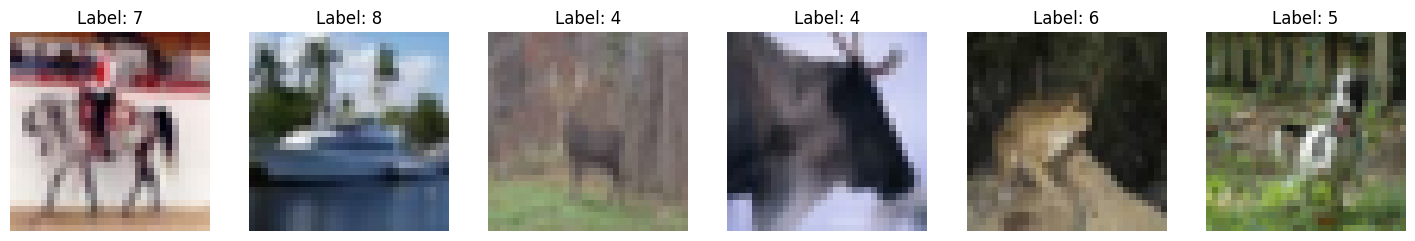

In [ ]:
# Visualize some examples from the combined training dataset
images, labels = [], []
for img, lbl in combined_train.take(6):
    images.append(img)
    labels.append(lbl)

fig, axes = plt.subplots(1, 6, figsize=(18, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i].numpy()}")
    ax.axis('off')
plt.show()


**Step 6: Preprocessing**

In [ ]:
IMG_SIZE = 32

# Define preprocessing pipeline
resize_rescale = Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1. / 255)
])

# Apply preprocessing to the datasets
def preprocess(image, label):
    image = resize_rescale(image)
    return image, label

combined_train = combined_train.map(preprocess).cache().batch(64).prefetch(tf.data.AUTOTUNE)
combined_val = combined_val.map(preprocess).cache().batch(64).prefetch(tf.data.AUTOTUNE)
combined_test = combined_test.map(preprocess).cache().batch(64).prefetch(tf.data.AUTOTUNE)


**Step 7: Build the Model**

In [ ]:
num_classes = 110  # CIFAR-10 (10 classes) + CIFAR-100 (100 classes)

model = Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes)
])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 110)                 │          28,270 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 646,062 (2.46 MB)

 Trainable params: 646,062 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

**Step 8: Train the Model**

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(
    combined_train,
    validation_data=combined_val,
    epochs=5
)


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 156s 123ms/step - accuracy: 0.2774 - loss: 2.2708 - val_accuracy: 0.0783 - val_loss: 10.2480
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 131s 105ms/step - accuracy: 0.3006 - loss: 2.3249 - val_accuracy: 0.1000 - val_loss: 8.5908
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 130s 104ms/step - accuracy: 0.3682 - loss: 2.0514 - val_accuracy: 0.1086 - val_loss: 6.8120
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 104ms/step - accuracy: 0.4234 - loss: 1.8641 - val_accuracy: 0.1195 - val_loss: 6.6219
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 130s 104ms/step - accuracy: 0.4477 - loss: 1.7881 - val_accuracy: 0.1382 - val_loss: 6.1715


**Step 9: Evaluate the Model**

In [ ]:
accuracy, loss = model.evaluate(combined_test)
print(f"Test Accuracy: {accuracy}")
print(f"Test Loss: {loss}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.0432 - loss: 8.3505
Test Accuracy: 6.136511325836182
Test Loss: 0.14059999585151672
